In [1]:
from pathlib import Path
import itertools
from functools import reduce

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.mixture import GaussianMixture

from lobib import DataLoader

sns.set_style("whitegrid")
rng = np.random.default_rng(1337)

In [2]:
def pl_select(condlist: list[pl.Expr], choicelist: list[pl.Expr]) -> pl.Expr:
    return reduce(
        lambda expr, cond_choice: expr.when(cond_choice[0]).then(cond_choice[1]),
        zip(condlist, choicelist),
        pl.when(condlist[0]).then(choicelist[0]),
    )

In [3]:
loader = DataLoader()
info = loader.ticker_info("AAL")

In [4]:
df = loader.load(
    "AAL",
    start_date=info["date"].min(),
    end_date=info["date"].max(),
    schema="qr",
    eager=True,
).sort(["date", "ts_event"])
df = df.filter(
    (
        pl.col("event_side")
        .replace({"A": 1, "B": -1})
        .cast(int)
        .mul(pl.col("event_queue_nbr"))
        >= 0
    )
    & pl.col("spread").le(4)
)
df = df.with_columns(pl.col("event").replace({"Trd_All": "Trd"}))
df = df.with_columns(
    pl.when(pl.col("event_queue_nbr").lt(0))
    .then(pl.col("event_queue_nbr").sub(pl.col("best_bid_nbr")).sub(1))
    .otherwise(pl.col("event_queue_nbr").sub(pl.col("best_ask_nbr")).add(1))
    .alias("event_q")
)

In [5]:
condlist = [pl.col("best_bid_nbr").eq(-i) for i in range(1, 11)]
choicelist = [pl.col(f"Q_{-i}") for i in range(1, 11)]
best_bid = pl_select(condlist, choicelist).alias("best_bid").truediv(500).ceil()

condlist = [pl.col("best_ask_nbr").eq(i) for i in range(1, 11)]
choicelist = [pl.col(f"Q_{i}") for i in range(1, 11)]
best_ask = pl_select(condlist, choicelist).alias("best_ask").truediv(500).ceil()
imb = ((best_bid - best_ask) / (best_bid + best_ask)).alias("imb")

df = df.with_columns(imb)

In [6]:
bins = np.arange(11, step=1) / 10
condlist = [
    *[
        pl.col("imb").ge(left) & pl.col("imb").lt(right)
        for left, right in zip(-bins[1:][::-1], -bins[:-1][::-1])
    ],
    pl.col("imb").eq(0),
    *[
        pl.col("imb").gt(left) & pl.col("imb").le(right)
        for left, right in zip(bins[:-1], bins[1:])
    ],
]
choicelist = [*(-bins[1:][::-1]), 0, *bins[1:]]
df = df.with_columns(pl_select(condlist, choicelist).alias("imb_bin"))

In [7]:
df = df.filter(pl.col("event_q").abs().le(2) & pl.col("spread").le(4))
df = df.with_columns(pl.when(pl.col("spread").ge(2)).then(2).otherwise(pl.col("spread")).alias("spread"))

In [8]:
dt = df.select(pl.col("ts_event").diff().over("date").cast(int).alias("dt"), "imb_bin", "spread").filter(pl.col("dt").gt(0))
dt = dt.with_columns(pl.col("dt").log10().alias("dt_log"))

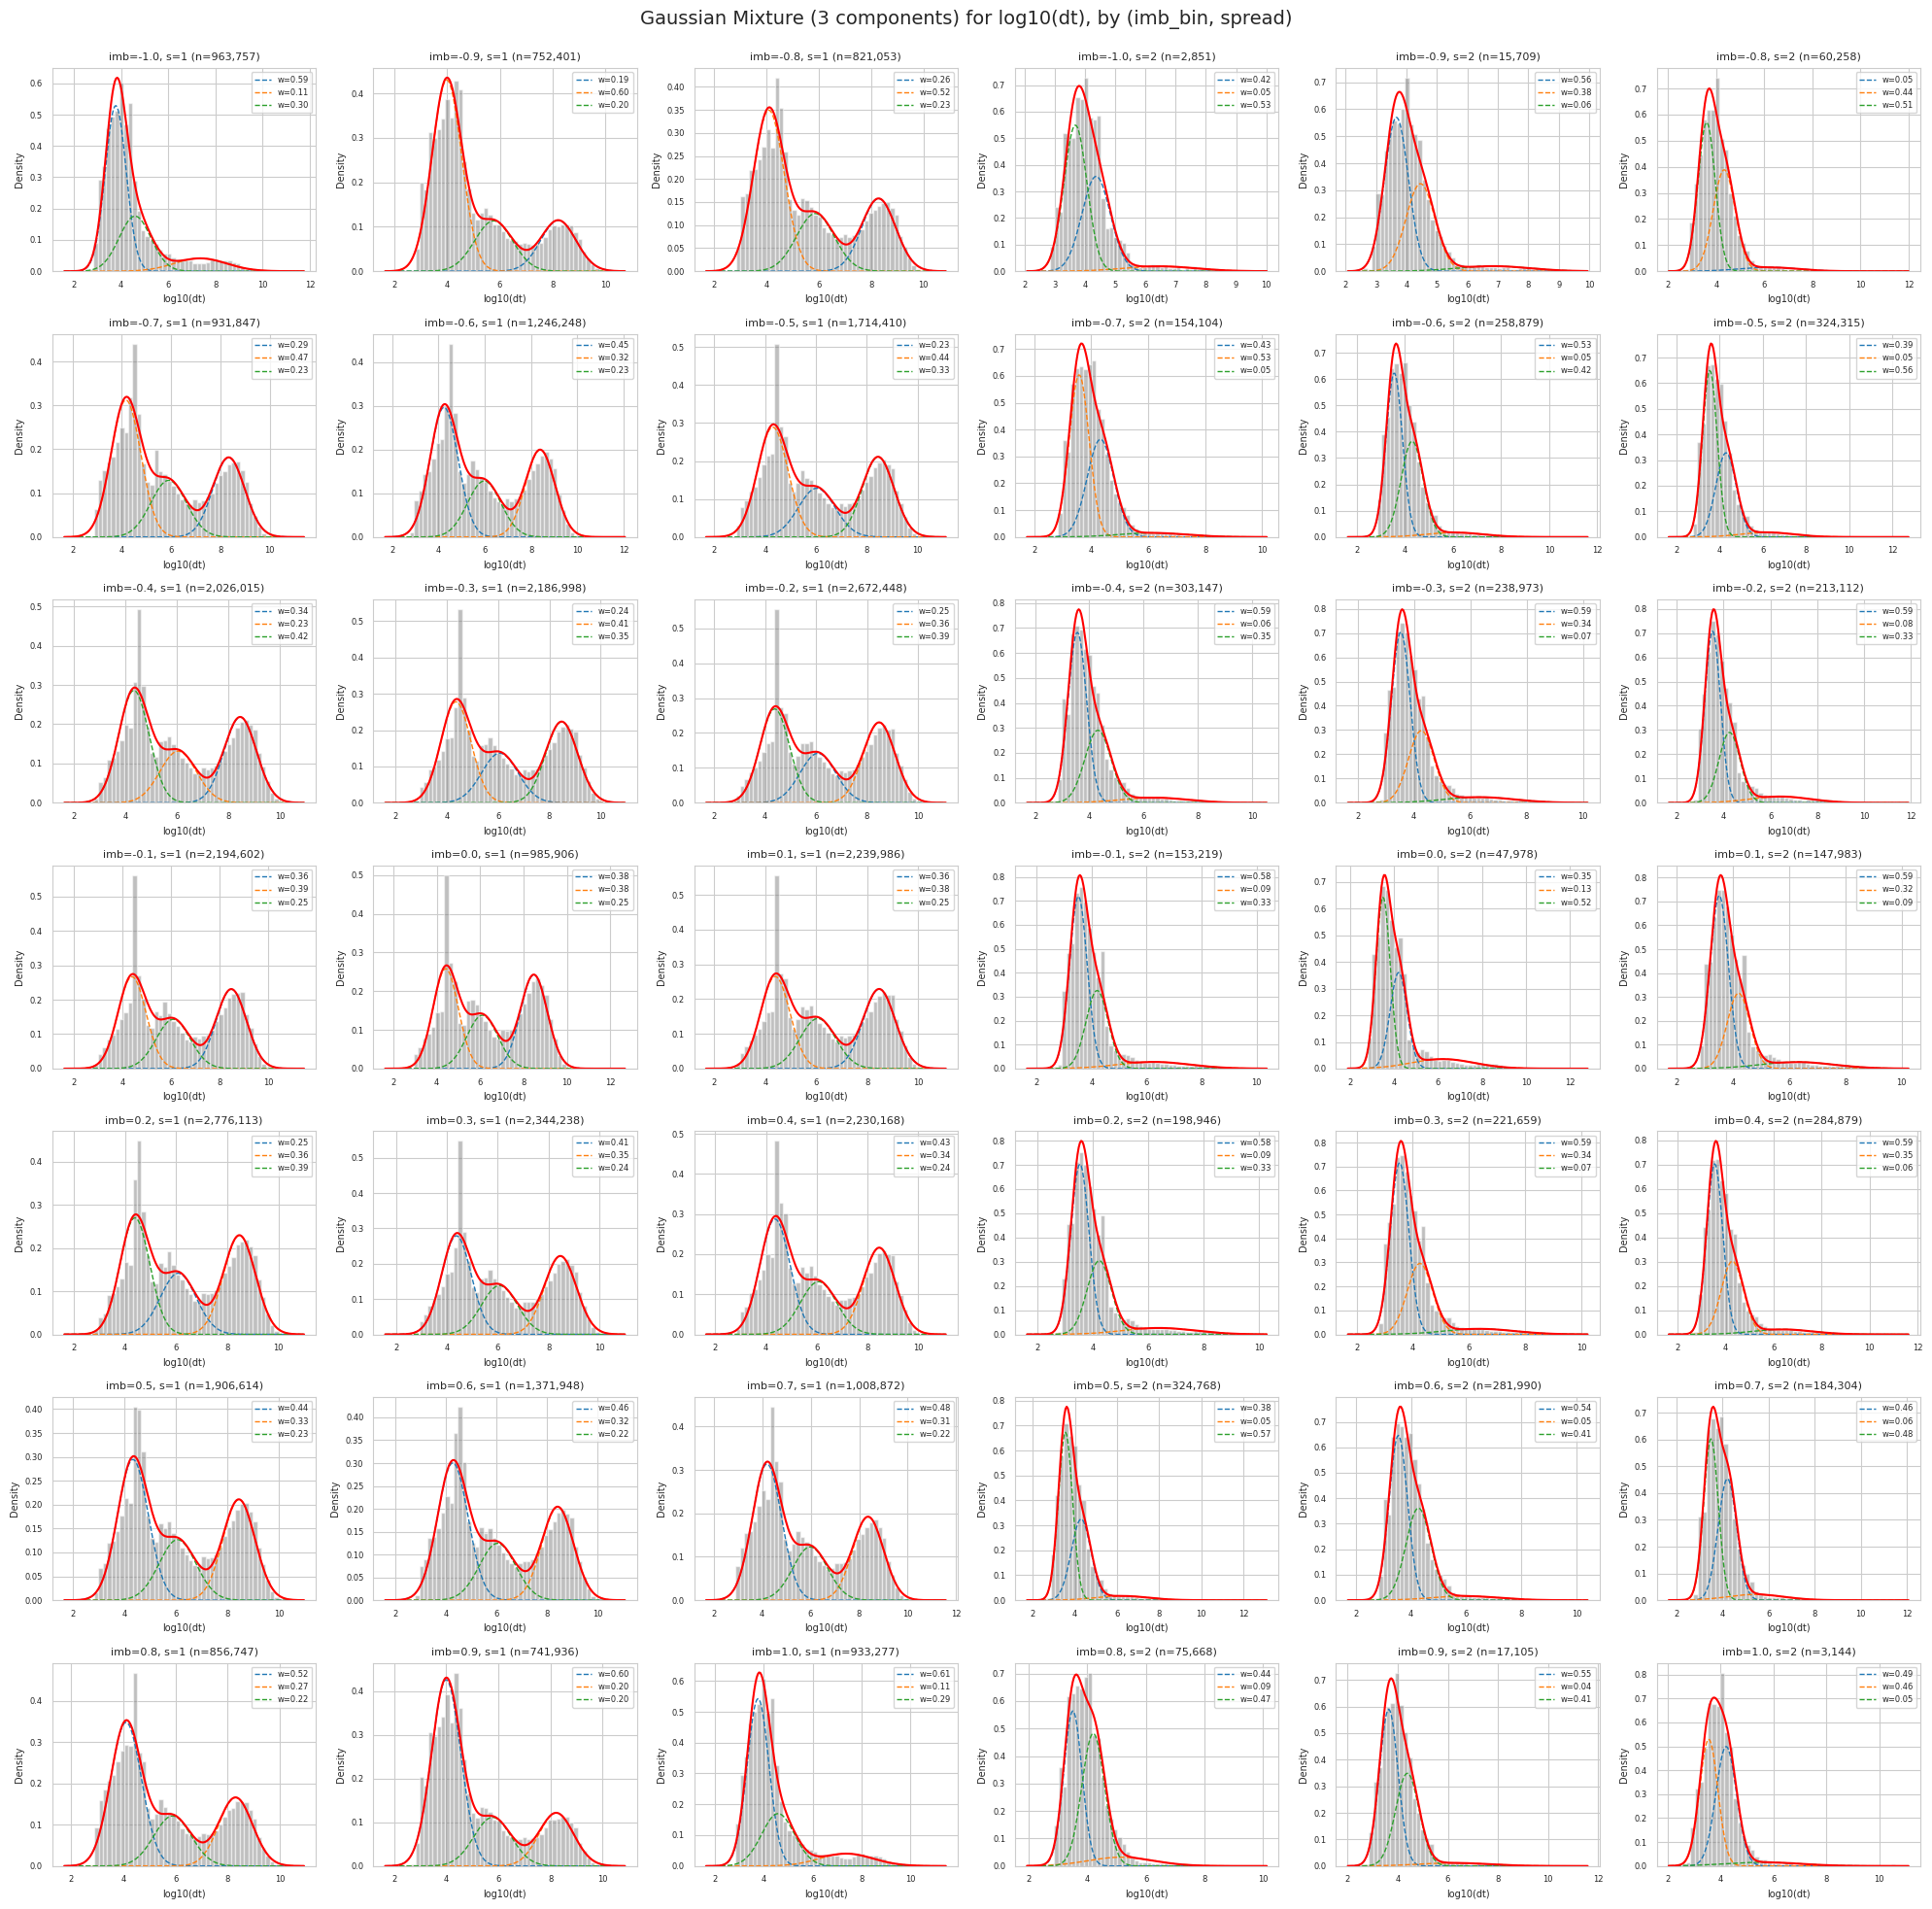

In [9]:
dt_filtered = dt.filter(pl.col("dt_log").gt(0))

# Get unique imbalance bins and spreads
imb_bins = sorted(dt_filtered["imb_bin"].unique().to_list())
spreads = sorted(dt_filtered["spread"].unique().to_list())

# Create figure with 21x2=42 subplots (7 rows x 6 cols, 3 per spread)
fig, axes = plt.subplots(7, 6, figsize=(20, 20))

# Fit GMM for each (imb_bin, spread) pair
gmm_params = []

for i, imb_bin in enumerate(imb_bins):
  for j, spread in enumerate(spreads):
      # Column: spread=1 uses cols 0,1,2; spread=2 uses cols 3,4,5
      col = (i % 3) + (j * 3)
      row = i // 3
      ax = axes[row, col]

      # Get data for this (imb_bin, spread) pair
      data = dt_filtered.filter(
          (pl.col("imb_bin").eq(imb_bin)) & (pl.col("spread").eq(spread))
      )["dt_log"].to_numpy()

      if len(data) < 10:
          ax.set_title(f"imb={imb_bin:.1f}, s={spread} (n={len(data)})", fontsize=8)
          ax.text(0.5, 0.5, "Insufficient data", ha="center", va="center", transform=ax.transAxes)
          continue

      log_dt = data.reshape(-1, 1)

      # Fit 3-component Gaussian mixture
      gmm = GaussianMixture(n_components=3, random_state=42).fit(log_dt)

      # Extract parameters
      means = gmm.means_.flatten()
      stds = np.sqrt(gmm.covariances_.flatten())
      weights = gmm.weights_

      # Store params (spread as 0 or 1 for C++ indexing)
      gmm_params.append({
          "imb_bin": imb_bin,
          "spread": spread - 1,  # 0 for spread=1, 1 for spread>=2
          "w1": weights[0], "mu1": means[0], "sigma1": stds[0],
          "w2": weights[1], "mu2": means[1], "sigma2": stds[1],
          "w3": weights[2], "mu3": means[2], "sigma3": stds[2],
          "n": len(data)
      })

      # Plot
      x = np.linspace(log_dt.min() - 0.5, log_dt.max() + 0.5, 200)
      pdf1 = weights[0] * stats.norm.pdf(x, means[0], stds[0])
      pdf2 = weights[1] * stats.norm.pdf(x, means[1], stds[1])
      pdf3 = weights[2] * stats.norm.pdf(x, means[2], stds[2])
      pdf_mix = pdf1 + pdf2 + pdf3

      ax.hist(log_dt, bins=50, density=True, alpha=0.5, color="gray")
      ax.plot(x, pdf1, "--", lw=1, label=f"w={weights[0]:.2f}")
      ax.plot(x, pdf2, "--", lw=1, label=f"w={weights[1]:.2f}")
      ax.plot(x, pdf3, "--", lw=1, label=f"w={weights[2]:.2f}")
      ax.plot(x, pdf_mix, "r-", lw=1.5)
      ax.set_title(f"imb={imb_bin:.1f}, s={spread} (n={len(data):,})", fontsize=8)
      ax.legend(fontsize=6, loc="upper right")
      ax.set_xlabel("log10(dt)", fontsize=7)
      ax.set_ylabel("Density", fontsize=7)
      ax.tick_params(labelsize=6)

plt.suptitle("Gaussian Mixture (3 components) for log10(dt), by (imb_bin, spread)", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

params_df = pl.DataFrame(gmm_params)

In [10]:
# params_df.write_csv("../data/AAL2/delta_t_mixtures.csv")

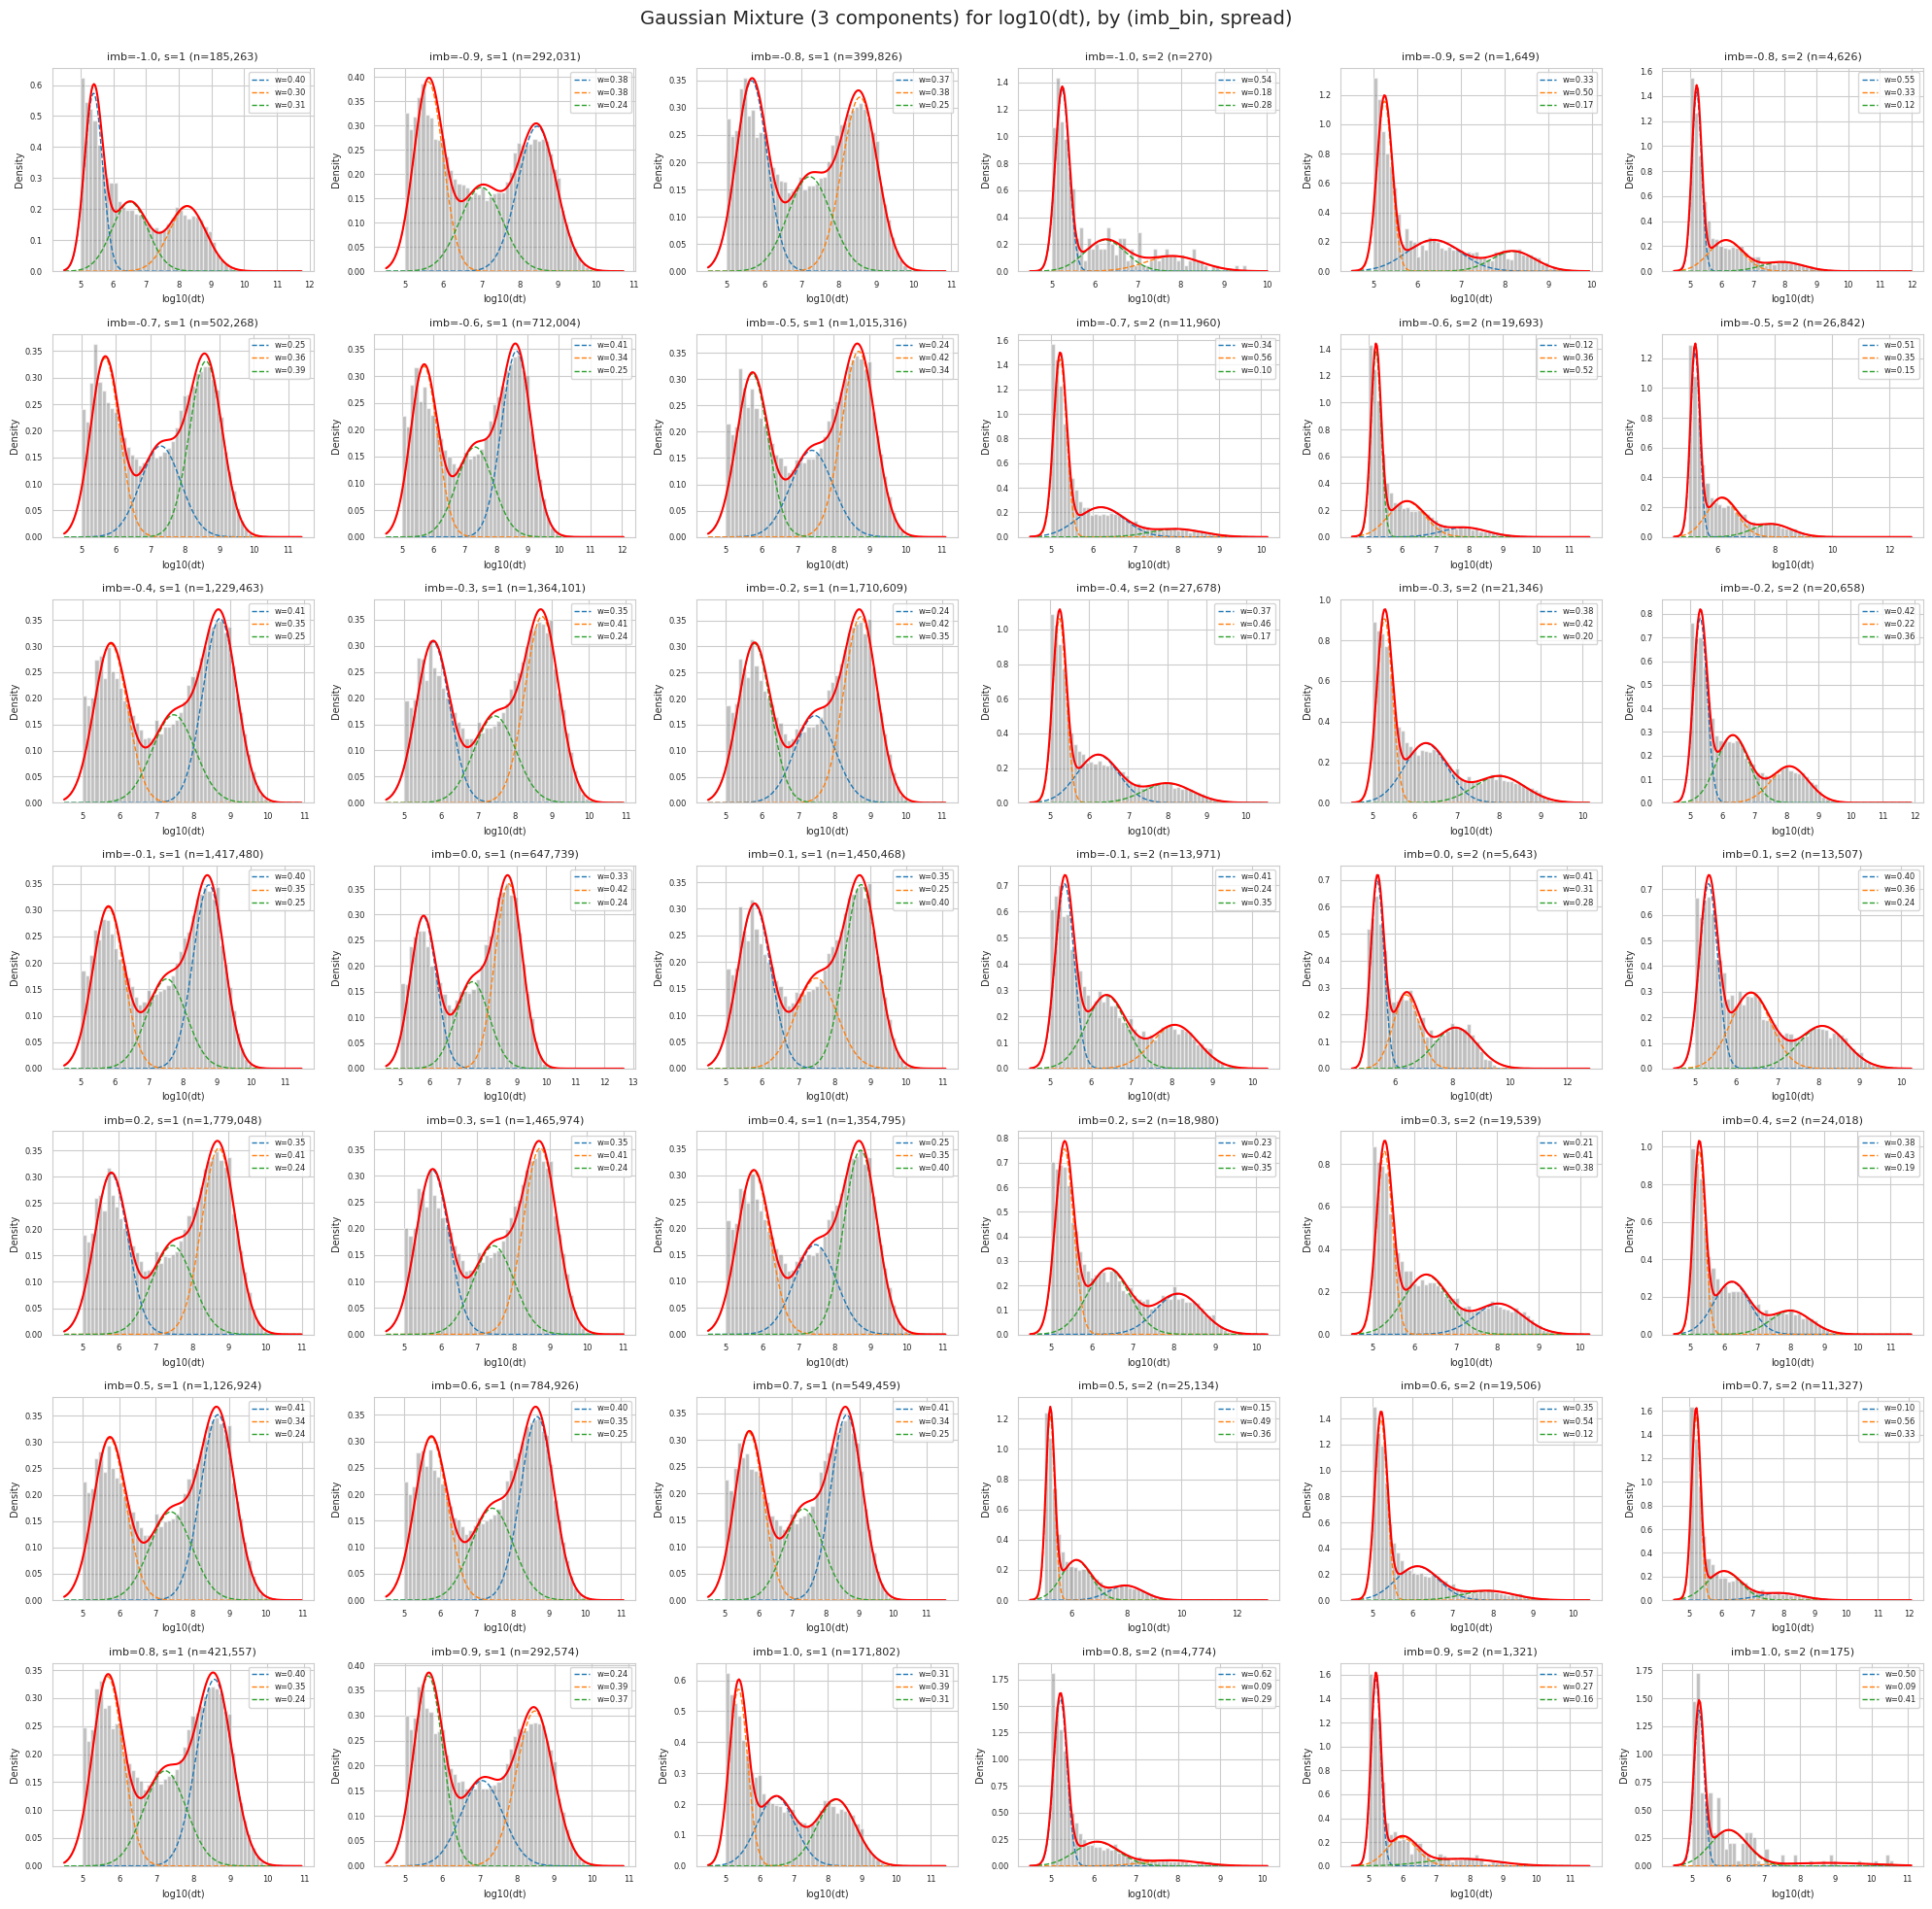

In [11]:
dt_filtered = dt.filter(pl.col("dt_log").gt(5))

# Get unique imbalance bins and spreads
imb_bins = sorted(dt_filtered["imb_bin"].unique().to_list())
spreads = sorted(dt_filtered["spread"].unique().to_list())

# Create figure with 21x2=42 subplots (7 rows x 6 cols, 3 per spread)
fig, axes = plt.subplots(7, 6, figsize=(20, 20))

# Fit GMM for each (imb_bin, spread) pair
gmm_params = []

for i, imb_bin in enumerate(imb_bins):
  for j, spread in enumerate(spreads):
      # Column: spread=1 uses cols 0,1,2; spread=2 uses cols 3,4,5
      col = (i % 3) + (j * 3)
      row = i // 3
      ax = axes[row, col]

      # Get data for this (imb_bin, spread) pair
      data = dt_filtered.filter(
          (pl.col("imb_bin").eq(imb_bin)) & (pl.col("spread").eq(spread))
      )["dt_log"].to_numpy()

      if len(data) < 10:
          ax.set_title(f"imb={imb_bin:.1f}, s={spread} (n={len(data)})", fontsize=8)
          ax.text(0.5, 0.5, "Insufficient data", ha="center", va="center", transform=ax.transAxes)
          continue

      log_dt = data.reshape(-1, 1)

      # Fit 3-component Gaussian mixture
      gmm = GaussianMixture(n_components=3, random_state=42).fit(log_dt)

      # Extract parameters
      means = gmm.means_.flatten()
      stds = np.sqrt(gmm.covariances_.flatten())
      weights = gmm.weights_

      # Store params (spread as 0 or 1 for C++ indexing)
      gmm_params.append({
          "imb_bin": imb_bin,
          "spread": spread - 1,  # 0 for spread=1, 1 for spread>=2
          "w1": weights[0], "mu1": means[0], "sigma1": stds[0],
          "w2": weights[1], "mu2": means[1], "sigma2": stds[1],
          "w3": weights[2], "mu3": means[2], "sigma3": stds[2],
          "n": len(data)
      })

      # Plot
      x = np.linspace(log_dt.min() - 0.5, log_dt.max() + 0.5, 200)
      pdf1 = weights[0] * stats.norm.pdf(x, means[0], stds[0])
      pdf2 = weights[1] * stats.norm.pdf(x, means[1], stds[1])
      pdf3 = weights[2] * stats.norm.pdf(x, means[2], stds[2])
      pdf_mix = pdf1 + pdf2 + pdf3

      ax.hist(log_dt, bins=50, density=True, alpha=0.5, color="gray")
      ax.plot(x, pdf1, "--", lw=1, label=f"w={weights[0]:.2f}")
      ax.plot(x, pdf2, "--", lw=1, label=f"w={weights[1]:.2f}")
      ax.plot(x, pdf3, "--", lw=1, label=f"w={weights[2]:.2f}")
      ax.plot(x, pdf_mix, "r-", lw=1.5)
      ax.set_title(f"imb={imb_bin:.1f}, s={spread} (n={len(data):,})", fontsize=8)
      ax.legend(fontsize=6, loc="upper right")
      ax.set_xlabel("log10(dt)", fontsize=7)
      ax.set_ylabel("Density", fontsize=7)
      ax.tick_params(labelsize=6)

plt.suptitle("Gaussian Mixture (3 components) for log10(dt), by (imb_bin, spread)", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

params_df = pl.DataFrame(gmm_params)

In [12]:
# params_df.write_csv("../data/AAL2/delta_t_mixtures_floored.csv")

In [13]:
dt_ = pl.read_parquet("../data/results/result_alpha_ema_impact.parquet")
dt_ = dt_["timestamp"].diff()
dt_ = dt_.filter(dt_ > 0)

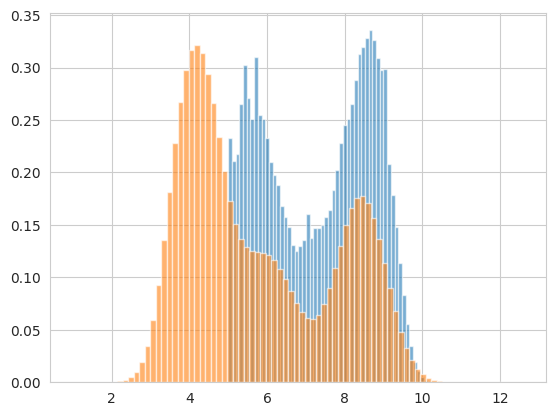

In [14]:
plt.hist(dt["dt_log"].filter(dt["dt_log"]>5), bins=80, alpha=.6, density=True)
plt.hist(dt_.log10(), bins=80, alpha=.6, density=True)
plt.show()

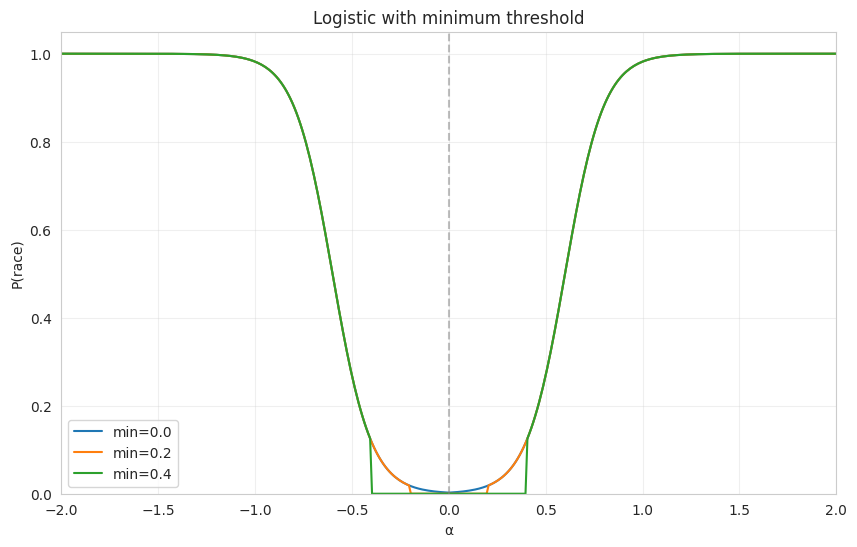

In [15]:
alpha = np.linspace(-2, 2, 400)

def p_logistic_with_min(a, min_thresh=0.2, threshold=0.5, steepness=10):
  p = 1 / (1 + np.exp(-steepness * (np.abs(a) - threshold)))
  p = np.where(np.abs(a) < min_thresh, 0, p)
  return p

fig, ax = plt.subplots(figsize=(10, 6))

for min_thresh in [0.0, 0.2, 0.4]:
  ax.plot(alpha, p_logistic_with_min(alpha, min_thresh=min_thresh, threshold=0.6, steepness=10),
          label=f"min={min_thresh}")

ax.set_xlabel("α")
ax.set_ylabel("P(race)")
ax.set_xlim(-2, 2)
ax.set_ylim(0, 1.05)
ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_title("Logistic with minimum threshold")
plt.show()


Laplace: loc=4.50, scale(b)=0.538


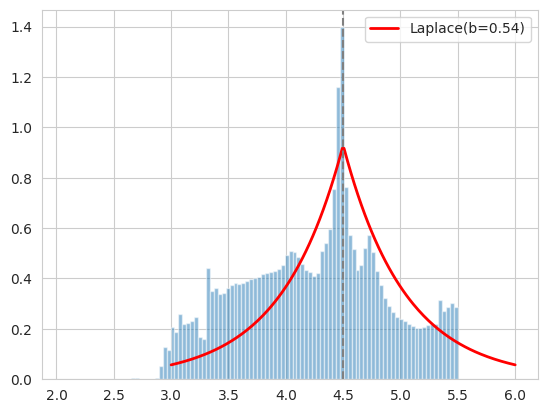

Peak region: [4.39, 4.55]


In [16]:
from scipy.stats import laplace

# Everything below some cutoff (exclude the large dt tail)
cutoff = 5.5  # exclude normal QR events
data = dt["dt_log"].filter(dt["dt_log"].lt(cutoff)).to_numpy()

# Fit Laplace (loc=mode, scale=b)
loc, scale = laplace.fit(data, floc=4.5)  # fix location at mode
print(f"Laplace: loc={loc:.2f}, scale(b)={scale:.3f}")

# Visualize
x = np.linspace(3, 6, 200)
plt.hist(data, bins=100, density=True, alpha=0.5)
plt.plot(x, laplace.pdf(x, loc=4.5, scale=scale), 'r-', lw=2, label=f'Laplace(b={scale:.2f})')
plt.axvline(4.5, color='gray', linestyle='--')
plt.legend()
plt.show()

from scipy.stats import gaussian_kde

data = dt["dt_log"].filter(dt["dt_log"].lt(5.5)).to_numpy()
kde = gaussian_kde(data)

x = np.linspace(3, 6, 500)
y = kde(x)
peak_idx = np.argmax(y)
peak_val = y[peak_idx]

# Find where density drops to 50% of peak
threshold = 0.5 * peak_val
left_idx = np.where(y[:peak_idx] < threshold)[0][-1] if any(y[:peak_idx] < threshold) else 0
right_idx = peak_idx + np.where(y[peak_idx:] < threshold)[0][0] if any(y[peak_idx:] < threshold) else len(y)-1

print(f"Peak region: [{x[left_idx]:.2f}, {x[right_idx]:.2f}]")

In [ ]:
data = dt["dt_log"].filter(dt["dt_log"].lt(5.5)).to_numpy()
kde = stats.gaussian_kde(data)

x = np.linspace(3, 6, 500)
y = kde(x)
peak_idx = np.argmax(y)
peak_val = y[peak_idx]

# Find where density drops to 50% of peak
threshold = 0.5 * peak_val
left_idx = np.where(y[:peak_idx] < threshold)[0][-1] if any(y[:peak_idx] < threshold) else 0
right_idx = peak_idx + np.where(y[peak_idx:] < threshold)[0][0] if any(y[peak_idx:] < threshold) else len(y)-1

left_bound = x[left_idx]
right_bound = x[right_idx]

print(f"Peak region: [{left_bound:.2f}, {right_bound:.2f}]")

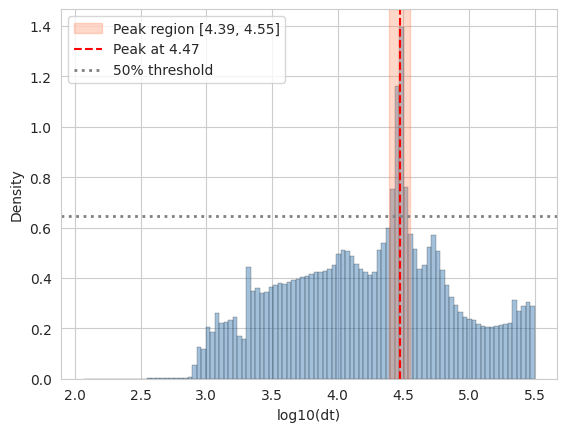

In [27]:
# Visualize
plt.hist(data, bins=100, density=True, alpha=0.5, color='steelblue', edgecolor='black', linewidth=0.3)
plt.axvspan(left_bound, right_bound, alpha=0.3, color='coral', label=f'Peak region [{left_bound:.2f}, {right_bound:.2f}]')
plt.axvline(x[peak_idx], color='red', linestyle='--', lw=1.5, label=f'Peak at {x[peak_idx]:.2f}')
plt.axhline(threshold, color='gray', linestyle=':', lw=2, label=f'50% threshold')
plt.xlabel("log10(dt)")
plt.ylabel("Density")
plt.legend()
plt.show()

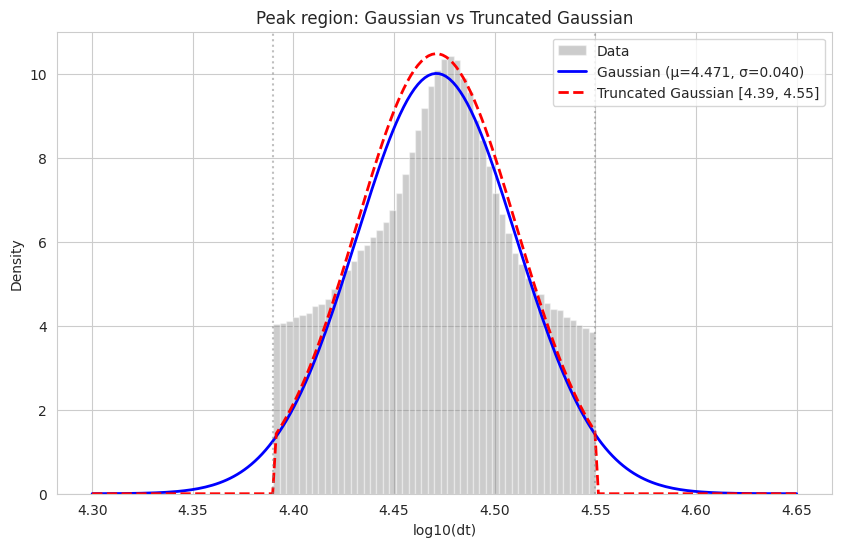

Normal: μ=4.4710, σ=0.0399


In [28]:
peak_data = dt["dt_log"].filter(
  (dt["dt_log"] > 4.39) & (dt["dt_log"] < 4.55)
).to_numpy()

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(peak_data, bins=50, density=True, alpha=0.4, color='gray', label='Data')

x = np.linspace(4.3, 4.65, 200)

# Fit normal
mu, sigma = stats.norm.fit(peak_data)
ax.plot(x, stats.norm.pdf(x, mu, sigma), 'blue', lw=2, label=f'Gaussian (μ={mu:.3f}, σ={sigma:.3f})')

# Truncated normal to [4.39, 4.55]
a, b = 4.39, 4.55
a_std, b_std = (a - mu) / sigma, (b - mu) / sigma
ax.plot(x, stats.truncnorm.pdf(x, a_std, b_std, loc=mu, scale=sigma), 'red', lw=2, linestyle='--',
      label=f'Truncated Gaussian [{a}, {b}]')

ax.axvline(a, color='gray', linestyle=':', alpha=0.5)
ax.axvline(b, color='gray', linestyle=':', alpha=0.5)
ax.legend()
ax.set_xlabel("log10(dt)")
ax.set_ylabel("Density")
ax.set_title("Peak region: Gaussian vs Truncated Gaussian")
plt.show()

print(f"Normal: μ={mu:.4f}, σ={sigma:.4f}")

In [31]:
pl.DataFrame({
  "mu": [mu],
  "sigma": [sigma],
  "lower": [a],
  "upper": [b]
}).write_csv("../data/AAL2/delta_distrib.csv")

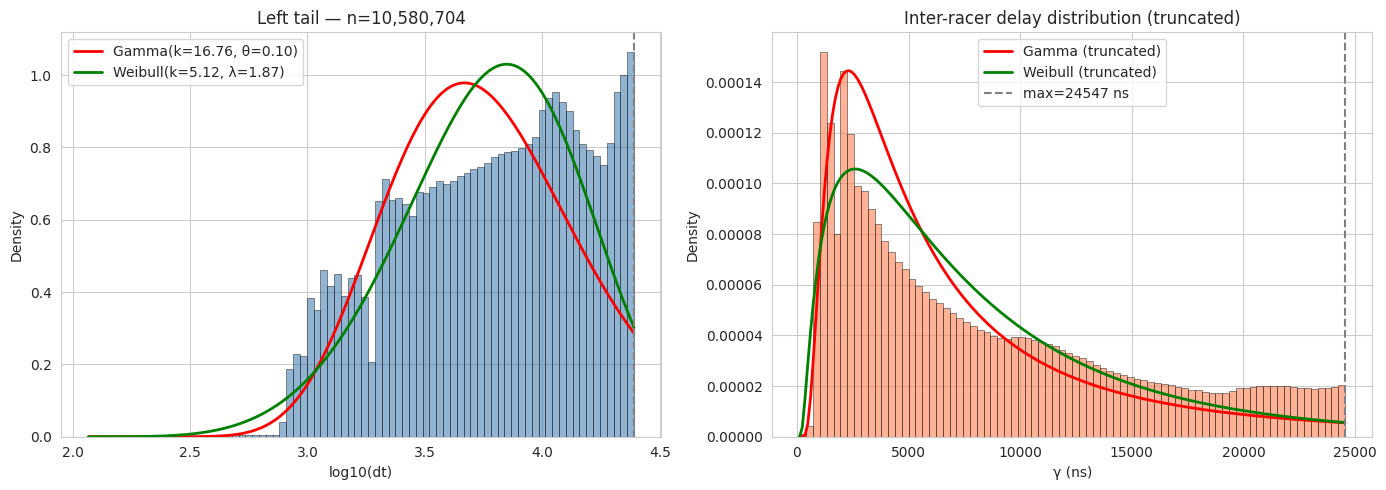

Log-likelihood: Gamma=-5575220.9, Weibull=-5004185.3

Gamma:   k=16.7627, θ=0.1021
Weibull: k=5.1241, λ=1.8675

ns range: [117, 24547]


In [32]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

left_tail = dt.filter(pl.col("dt_log").lt(4.39))["dt_log"]
# Shift data for fitting (both require x > 0)
left_tail_shifted = left_tail - left_tail.min() + 0.01

# Fit Gamma and Weibull
a_gamma, _, scale_gamma = gamma_dist.fit(left_tail_shifted, floc=0)
c_weibull, _, scale_weibull = weibull_min.fit(left_tail_shifted, floc=0)

# Left plot: log10 space
ax = axes[0]
ax.hist(left_tail, bins=80, alpha=0.6, color='steelblue', edgecolor='black', linewidth=0.5, density=True)
x_log = np.linspace(left_tail.min(), left_tail.max(), 200)
x_shifted = x_log - left_tail.min() + 0.01
ax.plot(x_log, gamma_dist.pdf(x_shifted, a_gamma, loc=0, scale=scale_gamma), 'r-', lw=2,
    label=f'Gamma(k={a_gamma:.2f}, θ={scale_gamma:.2f})')
ax.plot(x_log, weibull_min.pdf(x_shifted, c_weibull, loc=0, scale=scale_weibull), 'g-', lw=2,
    label=f'Weibull(k={c_weibull:.2f}, λ={scale_weibull:.2f})')
ax.axvline(4.39, color='gray', linestyle='--', lw=1.5)
ax.set_xlabel("log10(dt)")
ax.set_ylabel("Density")
ax.set_title(f"Left tail — n={len(left_tail):,}")
ax.legend()

# Right plot: nanoseconds (truncated at max)
gamma_ns = 10**left_tail
ns_min, ns_max = gamma_ns.min(), gamma_ns.max()

ax = axes[1]
ax.hist(gamma_ns, bins=80, alpha=0.6, color='coral', edgecolor='black', linewidth=0.5, density=True)

x_ns = np.linspace(ns_min, ns_max, 200)
x_log_t = np.log10(x_ns)
x_shifted_t = x_log_t - left_tail.min() + 0.01

# Transform PDFs: f_Y(y) = f_X(log10(y)) / (y * ln(10))
pdf_gamma_ns = gamma_dist.pdf(x_shifted_t, a_gamma, loc=0, scale=scale_gamma) / (x_ns * np.log(10))
pdf_weibull_ns = weibull_min.pdf(x_shifted_t, c_weibull, loc=0, scale=scale_weibull) / (x_ns * np.log(10))

# Renormalize to truncated region (so they integrate to 1 over [ns_min, ns_max])
from scipy.integrate import trapezoid
pdf_gamma_ns_norm = pdf_gamma_ns / trapezoid(pdf_gamma_ns, x_ns)
pdf_weibull_ns_norm = pdf_weibull_ns / trapezoid(pdf_weibull_ns, x_ns)

ax.plot(x_ns, pdf_gamma_ns_norm, 'r-', lw=2, label='Gamma (truncated)')
ax.plot(x_ns, pdf_weibull_ns_norm, 'g-', lw=2, label='Weibull (truncated)')
ax.axvline(ns_max, color='gray', linestyle='--', lw=1.5, label=f'max={ns_max:.0f} ns')
ax.set_xlabel("γ (ns)")
ax.set_ylabel("Density")
ax.set_title("Inter-racer delay distribution (truncated)")
ax.legend()

plt.tight_layout()
plt.show()

# Log-likelihood comparison
ll_gamma = np.sum(gamma_dist.logpdf(left_tail_shifted, a_gamma, loc=0, scale=scale_gamma))
ll_weibull = np.sum(weibull_min.logpdf(left_tail_shifted, c_weibull, loc=0, scale=scale_weibull))

print(f"Log-likelihood: Gamma={ll_gamma:.1f}, Weibull={ll_weibull:.1f}")
print(f"\nGamma:   k={a_gamma:.4f}, θ={scale_gamma:.4f}")
print(f"Weibull: k={c_weibull:.4f}, λ={scale_weibull:.4f}")
print(f"\nns range: [{ns_min:.0f}, {ns_max:.0f}]")


In [34]:
pl.DataFrame({
  "k": [a_gamma],
  "scale": [scale_gamma],
  "shift": [1.0],
  "max_log10": [4.39]
}).write_csv("../data/AAL2/gamma_distrib.csv")

pl.DataFrame({
  "k": [c_weibull],
  "scale": [scale_weibull],
  "shift": [1.0],
  "max_log10": [4.39]
}).write_csv("../data/AAL2/weibull_distrib.csv")

In [9]:
df_ = pl.read_parquet("../data/results/result_alpha_no_impact_k1.0_race.parquet")
dt_ = df_.select(pl.col("timestamp").diff().alias("dt")).drop_nulls().filter(pl.col("dt") > 0).with_columns(pl.col("dt").log10().alias("dt_log"))

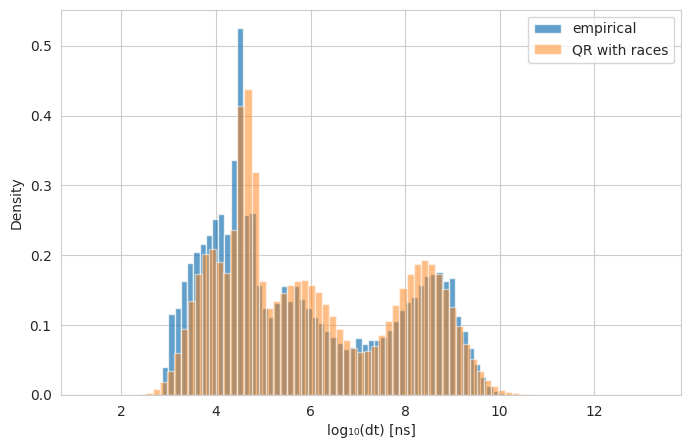

In [10]:
plt.figure(figsize=(8, 5))
    
plt.hist(dt["dt_log"], bins=80, density=True, alpha=.7, label="empirical")
plt.hist(dt_["dt_log"], bins=80, density=True, alpha=.5, label="QR with races")

plt.xlabel("log₁₀(dt) [ns]")
plt.ylabel("Density")
plt.legend()
plt.savefig("../figures/dt_fit_races.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

In [11]:
df_.filter(~pl.col("rejected"))["is_race"].value_counts(normalize=True)

is_race,proportion
bool,f64
false,0.726692
true,0.273308


In [12]:
df_.filter(~pl.col("rejected") & pl.col("is_race"))["type"].value_counts(normalize=True)

type,proportion
str,f64
"""Trade""",0.907395
"""Add""",0.092605


In [13]:
df_["type"].value_counts(normalize=True)

type,proportion
str,f64
"""CreateBid""",0.016077
"""Trade""",0.266452
"""Cancel""",0.337611
"""CreateAsk""",0.01598
"""Add""",0.36388


In [90]:
df["event"].value_counts(normalize=True)

event,proportion
str,f64
"""Create_Bid""",0.004456
"""Create_Ask""",0.004397
"""Can""",0.470488
"""Trd""",0.020706
"""Add""",0.499953
